Author: Sid Ali Rezetane

Binary Classification for stock market financial decisions : Regression Model Using LSTM units to predict future values of 
Closing_prices, Opening_Prices 
3 LSTM Models are built : using OHLC_Avg (the daily average of Opening Closing Maximum and Minimum prices), Closing_Prices, Opening_Prices 
Prediction of closing and opening prices using the three models then conclude daily labels and compare accuracy of models 


Data Used : Opening Prices,Max Prices,Min Prices,Closing Prices, Labels

In [15]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras.layers import LSTM
import preprocessing

define step size, load data and plot

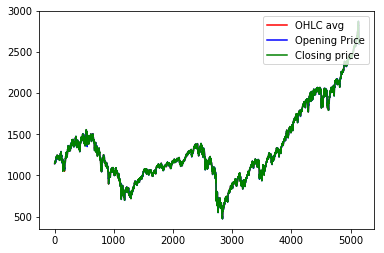

In [16]:
step_size = 1
# FOR REPRODUCIBILITY
np.random.seed(7)

# IMPORTING DATASET 
dataset = pd.read_csv('prova.csv', usecols=[1,2,3,4,5,6,7])
#dataset = dataset.reindex(index = dataset.index[::-1])

# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
#OHLC_avg = dataset.mean(axis = 1)
OHLC_avg =  dataset[['OHLC_avg']]
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]
open_val = dataset[['Open']]

labels =  dataset[['Label']]
classes =  preprocessing.classify(np.asarray(close_val),np.asarray(open_val))
classes = np.asarray(classes)

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, open_val, 'b', label = 'Opening Price')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

scale down the data values using minimax and split data using 80% ratio

In [17]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
close_val = np.reshape(close_val.values, (len(close_val),1))
open_val = np.reshape(open_val.values, (len(open_val),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
close_val = scaler.fit_transform(close_val)
open_val = scaler.fit_transform(open_val)
#classes = np.reshape(classes.values, len(classes))
#
## TRAIN-TEST SPLIT
train_OHLCs = int(len(OHLC_avg) * 0.8)
test_OHLCs = len(OHLC_avg) - train_OHLCs
train_classes , test_classes = classes[0:train_OHLCs] ,classes[train_OHLCs:len(OHLC_avg)-1] 
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLCs,:], OHLC_avg[train_OHLCs:len(OHLC_avg),:]
train_close, test_close = close_val[0:train_OHLCs,:], close_val[train_OHLCs:len(OHLC_avg),:]
train_open, test_open = open_val[0:train_OHLCs,:], open_val[train_OHLCs:len(OHLC_avg),:]
#

Turn data into time series dataset then reshape it to fit the model 

In [18]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX_OHLC, trainY_OHLC = preprocessing.new_dataset(train_OHLC, step_size)
testX_OHLC, testY_OHLC = preprocessing.new_dataset(test_OHLC, step_size)

trainX_close, trainY_close = preprocessing.new_dataset(train_close, step_size)
testX_close, testY_close = preprocessing.new_dataset(test_close, step_size)

trainX_open, trainY_open = preprocessing.new_dataset(train_open, step_size)
testX_open, testY_open = preprocessing.new_dataset(test_open, step_size)

# RESHAPING TRAIN AND TEST DATA
trainX_OHLC = np.reshape(trainX_OHLC, (trainX_OHLC.shape[0], 1, trainX_OHLC.shape[1]))
testX_OHLC = np.reshape(testX_OHLC, (testX_OHLC.shape[0], 1, testX_OHLC.shape[1]))

trainX_close = np.reshape(trainX_close, (trainX_close.shape[0], 1, trainX_close.shape[1]))
testX_close = np.reshape(testX_close, (testX_close.shape[0], 1, testX_close.shape[1]))

trainX_open = np.reshape(trainX_open, (trainX_open.shape[0], 1, trainX_open.shape[1]))
testX_open = np.reshape(testX_open, (testX_open.shape[0], 1, testX_open.shape[1]))
#

Set the three models 
first layer : LSTM 64 neuros with return sequence feature
Dropout 15% of neuros to avoid overfitting
second layer : Activation function ( Rectified Linear )
Third layer : LSTM 32 neuros 
Forth Layer : Dense neuron
Fifth Layer : Activation function ( Linear )

In [19]:
# LSTM MODEL OHCL
model_OHLC= Sequential()
model_OHLC.add(LSTM(64, input_shape=(1, step_size), return_sequences = True))
model_OHLC.add(Dropout(0.15))
model_OHLC.add(Activation('relu'))
model_OHLC.add(LSTM(32))
model_OHLC.add(Dense(1))
model_OHLC.add(Activation('linear'))


# LSTM MODEL Open
model_open= Sequential()
model_open.add(LSTM(64, input_shape=(1, step_size), return_sequences = True))
model_open.add(Activation('relu'))
model_open.add(LSTM(32))
model_open.add(Dense(1))
model_open.add(Activation('linear'))


# LSTM MODEL Close
model_close= Sequential()
model_close.add(LSTM(64, input_shape=(1, step_size), return_sequences = True))
model_close.add(Activation('relu'))
model_close.add(LSTM(32))
model_close.add(Dense(1))
model_close.add(Activation('linear'))


Compile : Loss function Mean Squared error, Optimizer : Adagrad 
Fit the model to training data, set 25 epochs and 10 batch sizes for training 
then predict

In [20]:
# MODEL COMPILING AND TRAINING
model_OHLC.compile(loss='mse', optimizer='adagrad',metrics=['accuracy']) # Try SGD, adam, adagrad and compare!!!
model_OHLC.fit(trainX_close, trainY_close, epochs=25, batch_size=10, verbose=2)

testPredict_close_OHLC = model_OHLC.predict(testX_close)
testPredict_open_OHLC = model_OHLC.predict(testX_open)

model_close.compile(loss='mse', optimizer='adagrad',metrics=['accuracy']) # Try SGD, adam, adagrad and compare!!!
model_close.fit(trainX_close, trainY_close, epochs=25, batch_size=10, verbose=2)

testPredict_close_close = model_close.predict(testX_close)

model_open.compile(loss='mse', optimizer='adagrad',metrics=['accuracy']) # Try SGD, adam, adagrad and compare!!!
model_open.fit(trainX_open, trainY_open, epochs=25, batch_size=10, verbose=2)

testPredict_open_open = model_open.predict(testX_open)

trainPredict = model_OHLC.predict(trainX_close)

Epoch 1/25
 - 4s - loss: 0.0033 - acc: 2.4319e-04
Epoch 2/25
 - 2s - loss: 5.2752e-04 - acc: 2.4319e-04
Epoch 3/25
 - 2s - loss: 4.5840e-04 - acc: 2.4319e-04
Epoch 4/25
 - 2s - loss: 4.2692e-04 - acc: 2.4319e-04
Epoch 5/25
 - 2s - loss: 4.0832e-04 - acc: 2.4319e-04
Epoch 6/25
 - 1s - loss: 4.1591e-04 - acc: 2.4319e-04
Epoch 7/25
 - 2s - loss: 3.9012e-04 - acc: 2.4319e-04
Epoch 8/25
 - 1s - loss: 3.8615e-04 - acc: 2.4319e-04
Epoch 9/25
 - 1s - loss: 3.9174e-04 - acc: 2.4319e-04
Epoch 10/25
 - 1s - loss: 3.8015e-04 - acc: 2.4319e-04
Epoch 11/25
 - 1s - loss: 3.8648e-04 - acc: 2.4319e-04
Epoch 12/25
 - 1s - loss: 3.9514e-04 - acc: 2.4319e-04
Epoch 13/25
 - 2s - loss: 3.7301e-04 - acc: 2.4319e-04
Epoch 14/25
 - 2s - loss: 3.8659e-04 - acc: 2.4319e-04
Epoch 15/25
 - 2s - loss: 3.6278e-04 - acc: 2.4319e-04
Epoch 16/25
 - 2s - loss: 3.8593e-04 - acc: 2.4319e-04
Epoch 17/25
 - 2s - loss: 3.7045e-04 - acc: 2.4319e-04
Epoch 18/25
 - 2s - loss: 3.6597e-04 - acc: 2.4319e-04
Epoch 19/25
 - 1s - los

Compute the daily labels based on predicted values of opening and closing prices

In [21]:
#classify 
classes_pre =preprocessing.classify(testPredict_close_close,testPredict_open_open)
classes_pre = np.asarray(classes_pre)
classes_pre_OHLC =preprocessing.classify(testPredict_close_OHLC,testPredict_open_OHLC)
classes_pre_OHLC = np.asarray(classes_pre_OHLC)
accuracy_classes = preprocessing.accuracy(test_classes[:len(classes_pre)],classes_pre)
accuracy_classes_OHLC = preprocessing.accuracy(test_classes[:len(classes_pre_OHLC)],classes_pre_OHLC)
#classes_s = classes_s.reindex(index = classes_s.index[::-1])

Train RMSE: 24.02
Test RMSE: 50.43


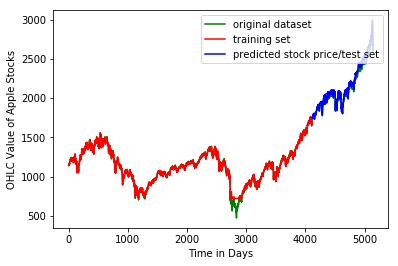

Last Day Value: 2685.3388671875
Next Day Value: 2816.292724609375
Close_Model and Open_Model Accuracy :  94.9268292683
OHLC_Model Accuracy :  96.0


In [22]:
## DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict_close_OHLC)
###
trainY_close = scaler.inverse_transform([trainY_close])
testY_close = scaler.inverse_transform([testY_close])

#trainY_OHLC = scaler.inverse_transform([trainY_OHLC])
#testY_OHLC = scaler.inverse_transform([testY_OHLC])
#
#trainY_open = scaler.inverse_transform([trainY_open])
#testY_open = scaler.inverse_transform([testY_open])


# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY_close[0], trainPredict[:,0]))
#trainScore = math.sqrt(mean_squared_error(trainY_OHLC[0], trainPredict[:,0]))
#trainScore = math.sqrt(mean_squared_error(trainY_open[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY_close[0], testPredict[:,0]))
#testScore = math.sqrt(mean_squared_error(testY_OHLC[0], testPredict[:,0]))
#testScore = math.sqrt(mean_squared_error(testY_open[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(close_val)
#trainPredictPlot = np.empty_like(OHLC_avg)
#trainPredictPlot = np.empty_like(open_val)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict


# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(close_val)
#testPredictPlot = np.empty_like(OHLC_avg)
#testPredictPlot = np.empty_like(open_val)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(close_val)-1, :] = testPredict
#testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict
#testPredictPlot[len(trainPredict)+(step_size*2)+1:len(open_val)-1, :] = testPredict



# DE-NORMALIZING MAIN DATASET 
close_val = scaler.inverse_transform(close_val)
OHLC_avg = scaler.inverse_transform(OHLC_avg)
#open_val = scaler.inverse_transform(open_val)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()


# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model_OHLC.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
print("Close_Model and Open_Model Accuracy : ",accuracy_classes)
print("OHLC_Model Accuracy : ",accuracy_classes_OHLC)

# print np.append(last_val, next_val)


Classification accuracy for models build using opening and closing prices : 94.92 % 
Classification accuracy for model built using the daily OHLC average price  : 96.00 % 